In [1]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from keras import layers,models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from keras.optimizers import Adam
from keras.applications import ResNet152
from keras import Model
from keras.layers.experimental import preprocessing
from keras.models import Sequential

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
# import itertools

2024-06-30 21:14:34.916638: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-30 21:14:34.916671: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-30 21:14:34.917526: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-30 21:14:34.923165: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [4]:
dataset = "../../Smartbin/Dataset/Crawl_dataset/Data_real"
walk_through_dir(dataset)

There are 3 directories and 0 images in '../../Smartbin/Dataset/Crawl_dataset/Data_real'.
There are 0 directories and 4061 images in '../../Smartbin/Dataset/Crawl_dataset/Data_real/UnRecycle'.
There are 0 directories and 8402 images in '../../Smartbin/Dataset/Crawl_dataset/Data_real/Organic'.
There are 0 directories and 7552 images in '../../Smartbin/Dataset/Crawl_dataset/Data_real/Recycle'.


In [5]:
data_dir = Path(dataset)

filepaths = list(data_dir.glob(r'**/*.JPG')) + list(data_dir.glob(r'**/*.jpg')) + list(data_dir.glob(r'**/*.png')) + list(data_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

In [6]:
image_df

,Filepath,Label
0,../../Smartbin/Dataset/Crawl_dataset/Data_real...,UnRecycle
1,../../Smartbin/Dataset/Crawl_dataset/Data_real...,UnRecycle
2,../../Smartbin/Dataset/Crawl_dataset/Data_real...,UnRecycle
3,../../Smartbin/Dataset/Crawl_dataset/Data_real...,UnRecycle
4,../../Smartbin/Dataset/Crawl_dataset/Data_real...,UnRecycle
...,...,...
21150,../../Smartbin/Dataset/Crawl_dataset/Data_real...,Recycle
21151,../../Smartbin/Dataset/Crawl_dataset/Data_real...,Recycle
21152,../../Smartbin/Dataset/Crawl_dataset/Data_real...,Recycle
21153,../../Smartbin/Dataset/Crawl_dataset/Data_real...,Recycle


In [7]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [8]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input
)

In [9]:
batch_size = 32
img_size = (200, 200)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 13540 validated image filenames belonging to 3 classes.
Found 3384 validated image filenames belonging to 3 classes.
Found 4231 validated image filenames belonging to 3 classes.


In [10]:
resize_and_rescale = tf.keras.Sequential([
    # layers.experimental.preprocessing.Resizing(224,224),
    layers.experimental.preprocessing.Rescaling(1. / 255),
])

2024-06-30 21:14:37.455938: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-30 21:14:37.456214: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-30 21:14:37.529103: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [11]:
pretrained_model = tf.keras.applications.ResNet152(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [12]:
inputs = pretrained_model.inputs
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(3, activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
checkpoint_path = "bags_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [14]:
early_stopping = EarlyStopping(monitor = "val_loss",
                               patience = 50,
                               restore_best_weights = True)

In [15]:
import time

class TimeHistory(Callback):
  def on_train_begin(self, logs=None):
    self.times = []
    self.epoch_start_time = time.time()  
  def on_epoch_end(self, epoch, logs=None):
    self.times.append(time.time() - self.epoch_start_time)
    self.epoch_start_time = time.time()
      
time_callback = TimeHistory()

In [16]:
history = model.fit(
  train_images,
  steps_per_epoch=len(train_images),
  validation_data=val_images,
  validation_steps=len(val_images),
  epochs=200,
  callbacks=[
    early_stopping,
    create_tensorboard_callback("training_logs", "bag_classification"),
    checkpoint_callback,
    time_callback
  ]
)

Saving TensorBoard log files to: training_logs/bag_classification/20240630-211451


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/200


2024-06-30 21:14:57.728034: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-06-30 21:15:27.295217: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fd9e8e36d50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-30 21:15:27.295252: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-06-30 21:15:27.295261: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-06-30 21:15:27.300332: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1719782127.368357 2881489 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


424/424 [==============================] - 492s 1s/step - loss: 0.1717 - accuracy: 0.9397 - val_loss: 0.0573 - val_accuracy: 0.9799
Epoch 2/200
424/424 [==============================] - 395s 932ms/step - loss: 0.0564 - accuracy: 0.9821 - val_loss: 0.0469 - val_accuracy: 0.9840
Epoch 3/200
424/424 [==============================] - 392s 925ms/step - loss: 0.0367 - accuracy: 0.9875 - val_loss: 0.0449 - val_accuracy: 0.9837
Epoch 4/200
424/424 [==============================] - 392s 924ms/step - loss: 0.0275 - accuracy: 0.9913 - val_loss: 0.0476 - val_accuracy: 0.9835
Epoch 5/200
424/424 [==============================] - 394s 930ms/step - loss: 0.0162 - accuracy: 0.9952 - val_loss: 0.0412 - val_accuracy: 0.9867
Epoch 6/200
424/424 [==============================] - 404s 952ms/step - loss: 0.0121 - accuracy: 0.9969 - val_loss: 0.0438 - val_accuracy: 0.9870
Epoch 7/200
424/424 [==============================] - 392s 924ms/step - loss: 0.0072 - accuracy: 0.9982 - val_loss: 0.0530 - val_acc

In [17]:
total_training_time = sum(time_callback.times)
print("Total training time:", total_training_time, "seconds")

Total training time: 13812.578694343567 seconds


In [18]:
results = model.evaluate(test_images, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.03616
Test Accuracy: 99.05%


133/133 [==============================] - 33s 236ms/step
The first 10 predictions: ['UnRecycle', 'Recycle', 'Organic', 'Recycle', 'Recycle', 'Organic', 'Recycle', 'UnRecycle', 'Organic', 'Recycle']


SyntaxError: not a PNG file (<string>)

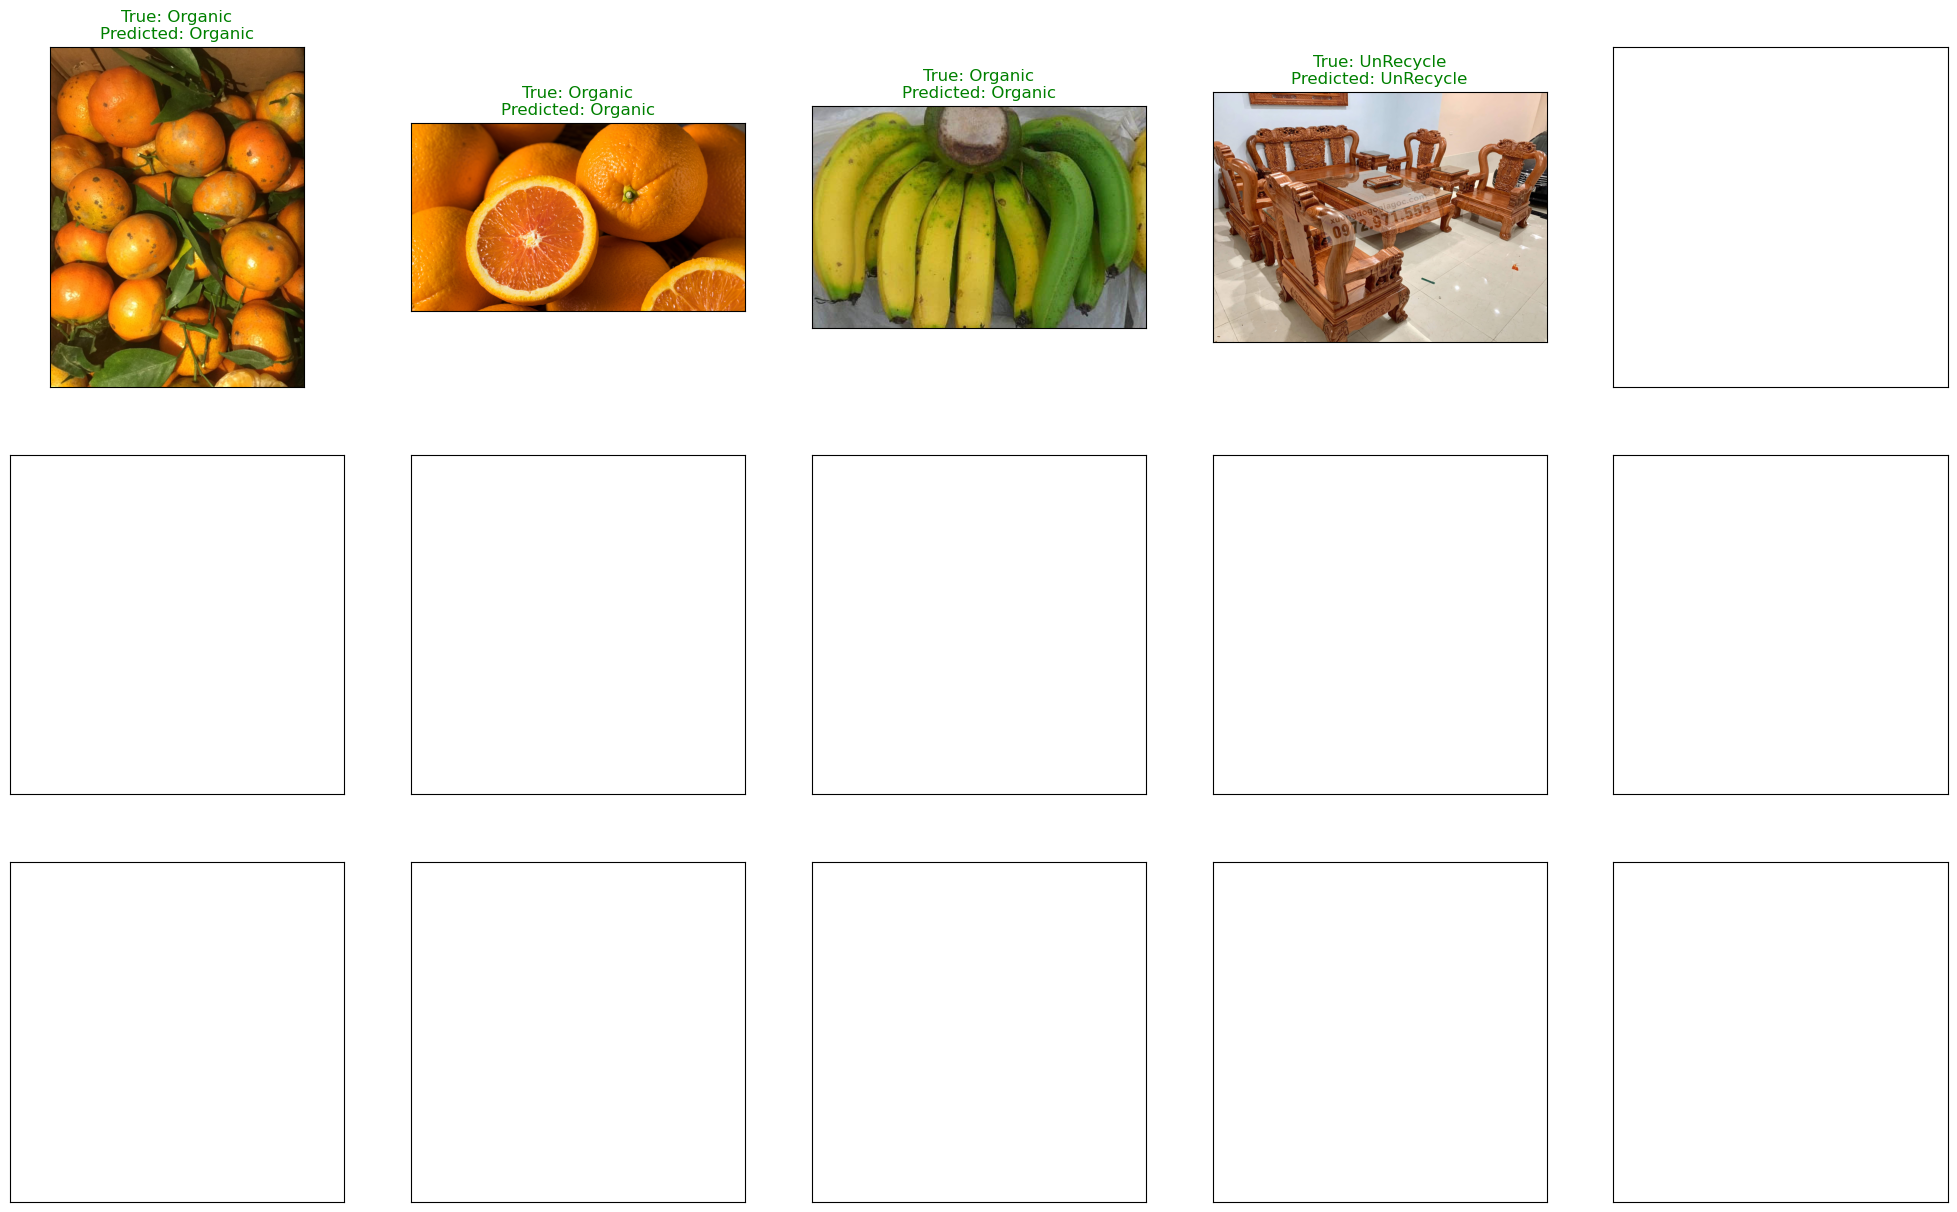

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
history.history

# In ra dự đoán và so sánh với nhãn thực tế
pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)

labels = (train_images.class_indices)
labels = dict((v, k) for k, v in labels.items())
pred = [labels[k] for k in pred]

print(f'The first 10 predictions: {pred[:10]}')

# Hiển thị một số ví dụ dự đoán
# 0.

In [20]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 10 predictions: {pred[:10]}')

133/133 [==============================] - 31s 233ms/step
The first 10 predictions: ['UnRecycle', 'Recycle', 'Organic', 'Recycle', 'Recycle', 'Organic', 'Recycle', 'UnRecycle', 'Organic', 'Recycle']


In [21]:
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
Organic,0.991021,0.991578,0.991299,1781.000000
Recycle,0.988300,0.990130,0.989214,1621.000000
UnRecycle,0.993939,0.989144,0.991536,829.000000
accuracy,0.990546,0.990546,0.990546,0.990546
macro avg,0.991087,0.990284,0.990683,4231.000000
weighted avg,0.990551,0.990546,0.990547,4231.000000
